In [34]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# 1. Load data. Cleaning data - Present steps...and corresponding code
import numpy as np
import pandas as pd

# Load dataset trực tiếp từ GitHub
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

In [35]:
# Cleaning data
# Kiểm tra null:
print(df.isnull().sum())
# Kiểm tra giá trị bằng 0 (các cột không nên có 0 như Glucose, BP, BMI...):
print(df.eq(0).sum())
# Thay thế 0 bằng NaN và điền bằng mean:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
    df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.nan)

df.fillna(df.mean(), inplace=True)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [36]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# 2. Feature Selection (Chọn 5 features)
# Dựa vào correlation với Outcome:
corr = df.corr()['Outcome'].sort_values(ascending=False)
print(corr)

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.215299
Insulin                     0.214411
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


In [37]:
# Các feature quan trọng nhất: Glucose, BMI, Age, Insulin, Pregnancies.
X = df[['Glucose','BMI','Age','Insulin','Pregnancies']]
y = df['Outcome']

In [38]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# Using models (including Deep MLP 7+ layers) and split train/val/test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=200))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "SVM (Linear)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='linear', probability=True))
    ]),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Deep MLP (7+)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64,64,32,32,16,16,8),
            activation="relu",
            solver="adam",
            alpha=1e-4,
            batch_size=32,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=42
        ))
    ])
}

# Split 60/20/20: train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [39]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import math

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_acc = accuracy_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = math.sqrt(train_mse)

    val_acc = accuracy_score(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_rmse = math.sqrt(val_mse)

    overfit_gap_rmse = val_rmse - train_rmse
    overfit_gap_acc = train_acc - val_acc

    results[name] = {
        "train_acc": train_acc, "val_acc": val_acc,
        "train_mae": train_mae, "val_mae": val_mae,
        "train_mse": train_mse, "val_mse": val_mse,
        "train_rmse": train_rmse, "val_rmse": val_rmse,
        "overfit_gap_rmse": overfit_gap_rmse,
        "overfit_gap_acc": overfit_gap_acc
    }

results_df = pd.DataFrame(results).T.sort_values(by=["val_rmse", "overfit_gap_rmse"]) 
print("=== Train/Val metrics and overfitting gaps ===")
print(results_df)


=== Train/Val metrics and overfitting gaps ===
                     train_acc   val_acc  train_mae   val_mae  train_mse  \
Logistic Regression   0.795652  0.759740   0.204348  0.240260   0.204348   
KNN                   0.843478  0.746753   0.156522  0.253247   0.156522   
Random Forest         1.000000  0.733766   0.000000  0.266234   0.000000   
SVM (Linear)          0.793478  0.714286   0.206522  0.285714   0.206522   
Deep MLP (7+)         0.902174  0.694805   0.097826  0.305195   0.097826   
Decision Tree         1.000000  0.662338   0.000000  0.337662   0.000000   

                      val_mse  train_rmse  val_rmse  overfit_gap_rmse  \
Logistic Regression  0.240260    0.452048  0.490163          0.038114   
KNN                  0.253247    0.395628  0.503236          0.107608   
Random Forest        0.266234    0.000000  0.515978          0.515978   
SVM (Linear)         0.285714    0.454447  0.534522          0.080076   
Deep MLP (7+)        0.305195    0.312772  0.552444    

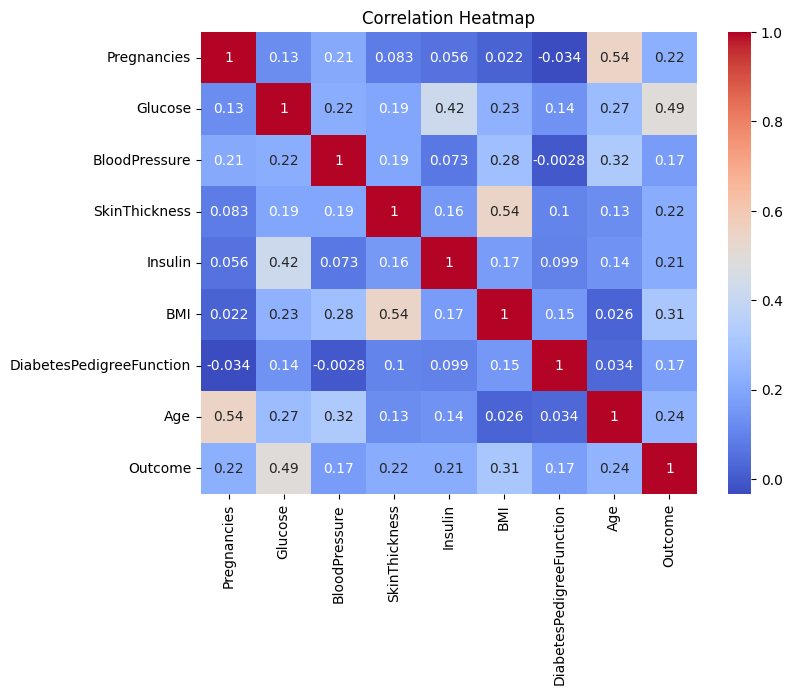

In [40]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Heatmap correlation
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

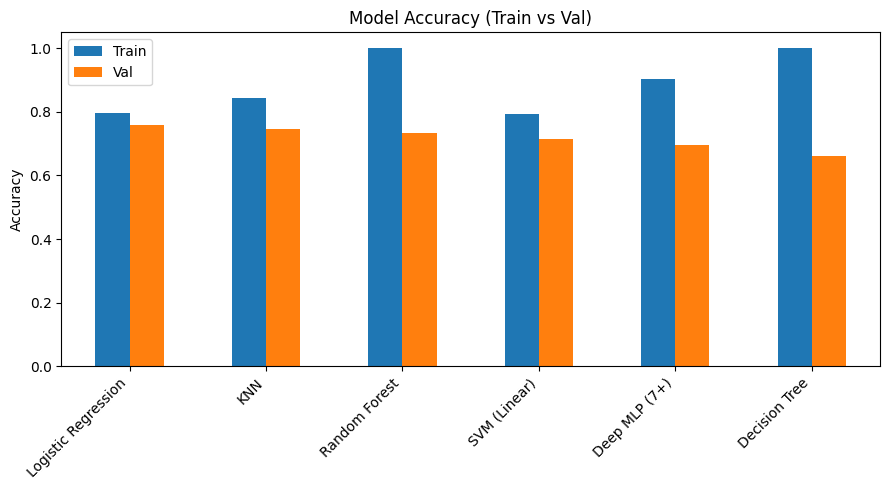

In [41]:
# 2. Accuracy comparison (Train vs Val)
ax = results_df[["train_acc","val_acc"]].rename(columns={"train_acc":"Train","val_acc":"Val"}).plot(kind='bar', figsize=(9,5), title="Model Accuracy (Train vs Val)")
ax.set_ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

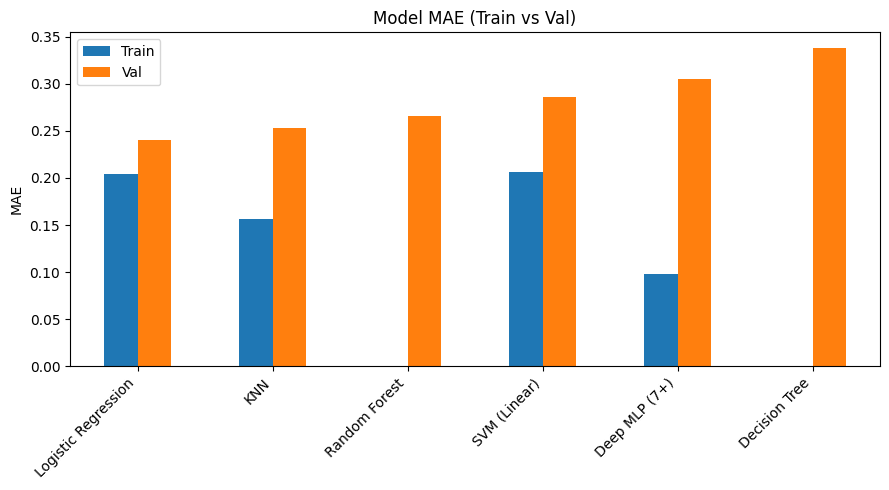

In [42]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# 3. MAE comparison (Train vs Val)
ax = results_df[["train_mae","val_mae"]].rename(columns={"train_mae":"Train","val_mae":"Val"}).plot(kind='bar', figsize=(9,5), title="Model MAE (Train vs Val)")
ax.set_ylabel("MAE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

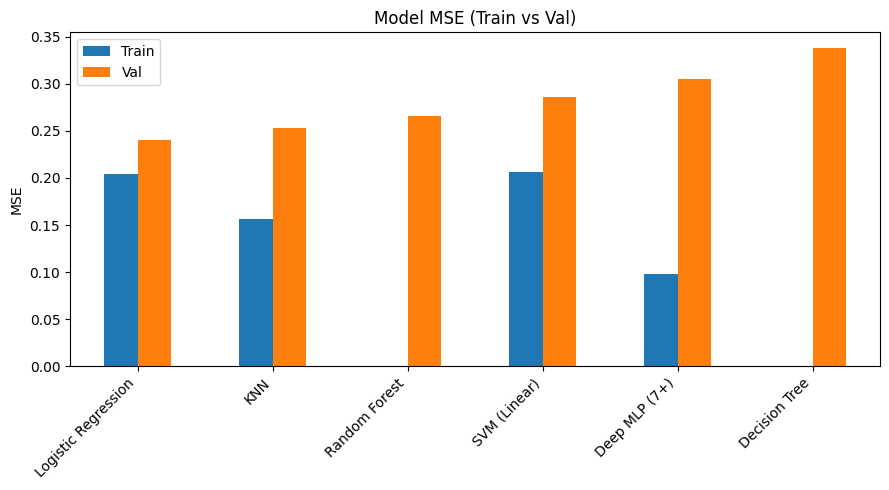

In [43]:
# 4. MSE comparison (Train vs Val)
ax = results_df[["train_mse","val_mse"]].rename(columns={"train_mse":"Train","val_mse":"Val"}).plot(kind='bar', figsize=(9,5), title="Model MSE (Train vs Val)")
ax.set_ylabel("MSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

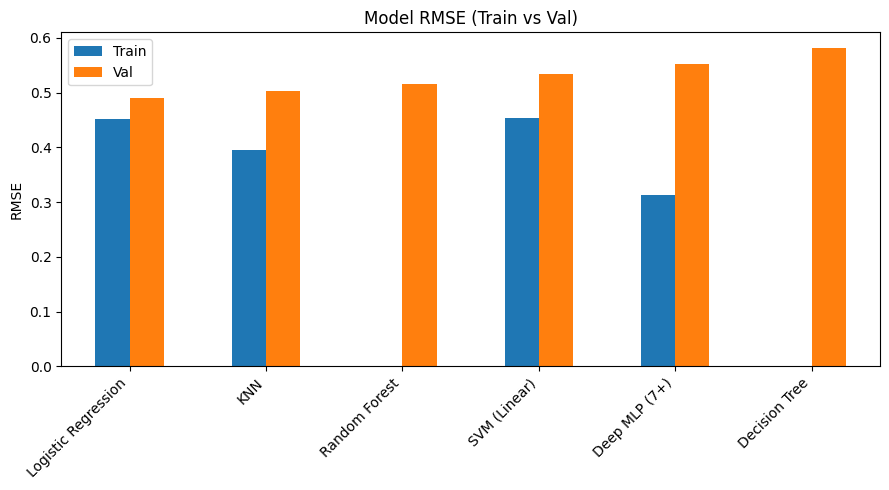

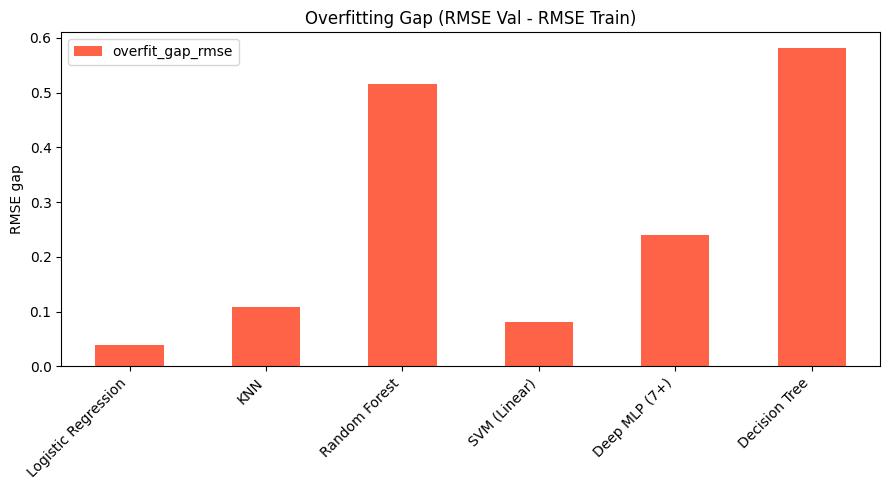

In [44]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# 5. RMSE comparison (Train vs Val)
ax = results_df[["train_rmse","val_rmse"]].rename(columns={"train_rmse":"Train","val_rmse":"Val"}).plot(kind='bar', figsize=(9,5), title="Model RMSE (Train vs Val)")
ax.set_ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Overfitting gap visualization (Val RMSE - Train RMSE)
ax = results_df[["overfit_gap_rmse"]].plot(kind='bar', figsize=(9,5), title="Overfitting Gap (RMSE Val - RMSE Train)", color=['tomato'])
ax.set_ylabel("RMSE gap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# Select best model by lowest validation RMSE, evaluate on test, and save
best_model_name = results_df['val_rmse'].idxmin()
best_model = models[best_model_name]

# Retrain on train+val to leverage more data before testing
import pandas as pd
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_train_val, y_train_val)

# Evaluate on held-out test
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import math

y_pred_test = best_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = math.sqrt(test_mse)

print(f"Best model (by Val RMSE): {best_model_name}")
print({"test_accuracy": test_acc, "test_mae": test_mae, "test_mse": test_mse, "test_rmse": test_rmse})

# Save best model for deployment
import pickle
pickle.dump(best_model, open("diabetes_model.sav", "wb"))
print("Saved best model to diabetes_model.sav")


Best model (by Val RMSE): Logistic Regression
{'test_accuracy': 0.7402597402597403, 'test_mae': 0.2597402597402597, 'test_mse': 0.2597402597402597, 'test_rmse': 0.5096471914376255}
Saved best model to diabetes_model.sav


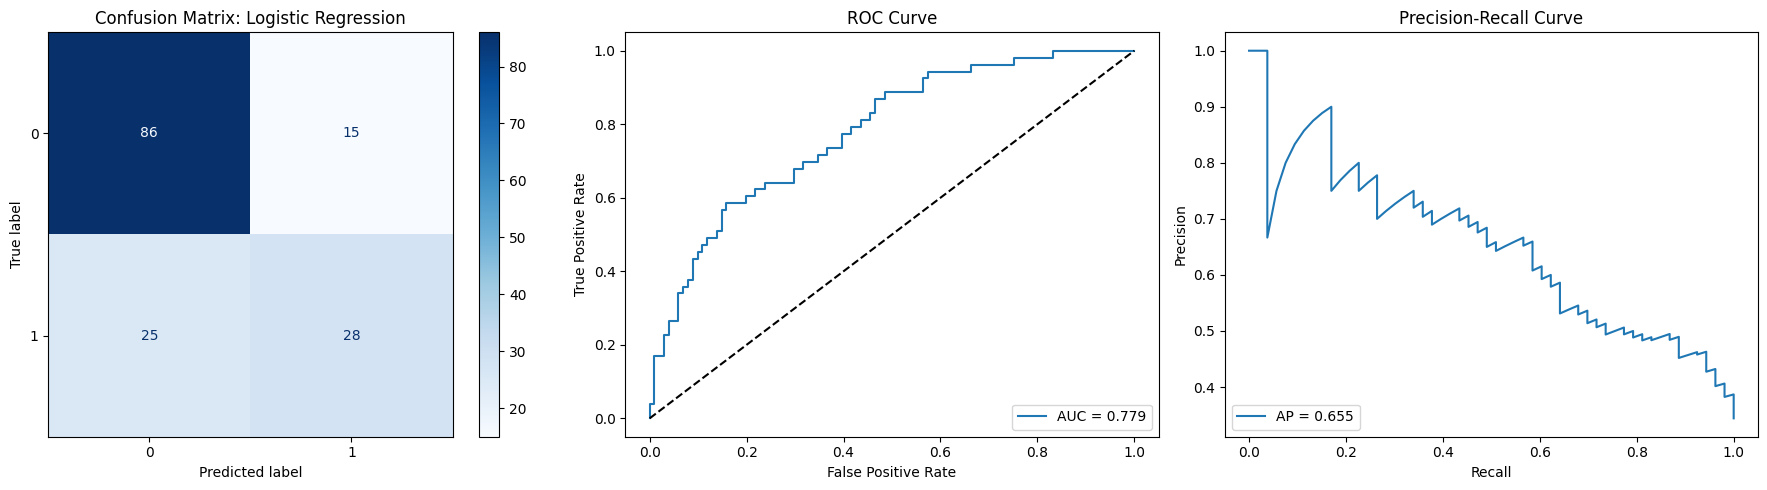

In [46]:
# Confusion matrix, ROC and PR curves for best model on test set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score

# Ensure best_model and best_model_name exist (from previous cell)
try:
    best_model
    best_model_name
except NameError:
    raise RuntimeError("Please run the model selection cell first.")

# Predictions and probabilities for ROC/PR
y_pred_test = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)[:,1]
elif hasattr(best_model, "decision_function"):
    # Fallback for models without predict_proba
    scores = best_model.decision_function(X_test)
    # Scale decision function to [0,1] via min-max for PR computation
    s_min, s_max = scores.min(), scores.max()
    y_score = (scores - s_min) / (s_max - s_min + 1e-12)
else:
    # As a last resort, use predictions as scores
    y_score = y_pred_test.astype(float)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=axes[0], cmap='Blues')
axes[0].set_title(f"Confusion Matrix: {best_model_name}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)
axes[2].plot(rec, prec, label=f"AP = {ap:.3f}")
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend(loc='lower left')

plt.tight_layout()
plt.show()


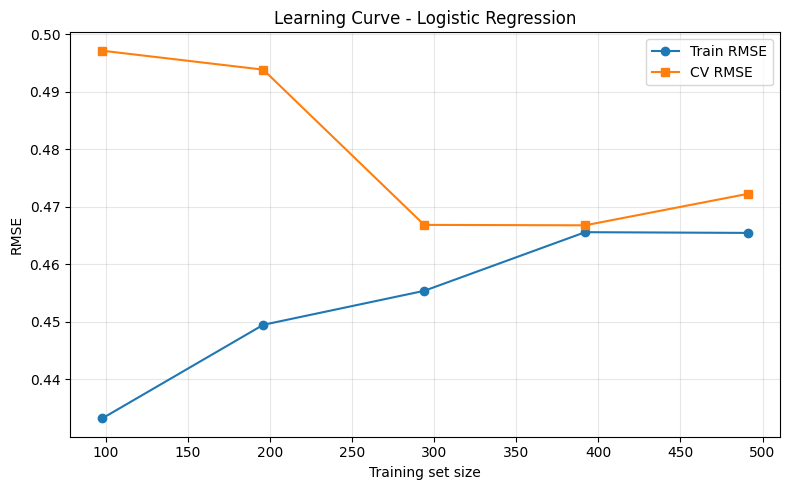

In [47]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# Learning curve for the selected best model (RMSE-based)
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# We evaluate negative RMSE so we convert to RMSE later
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train_val,
    y=y_train_val,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=None,
    train_sizes=np.linspace(0.2, 1.0, 5),
    random_state=42 if hasattr(best_model, 'random_state') else None
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse, marker='s', label='CV RMSE')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


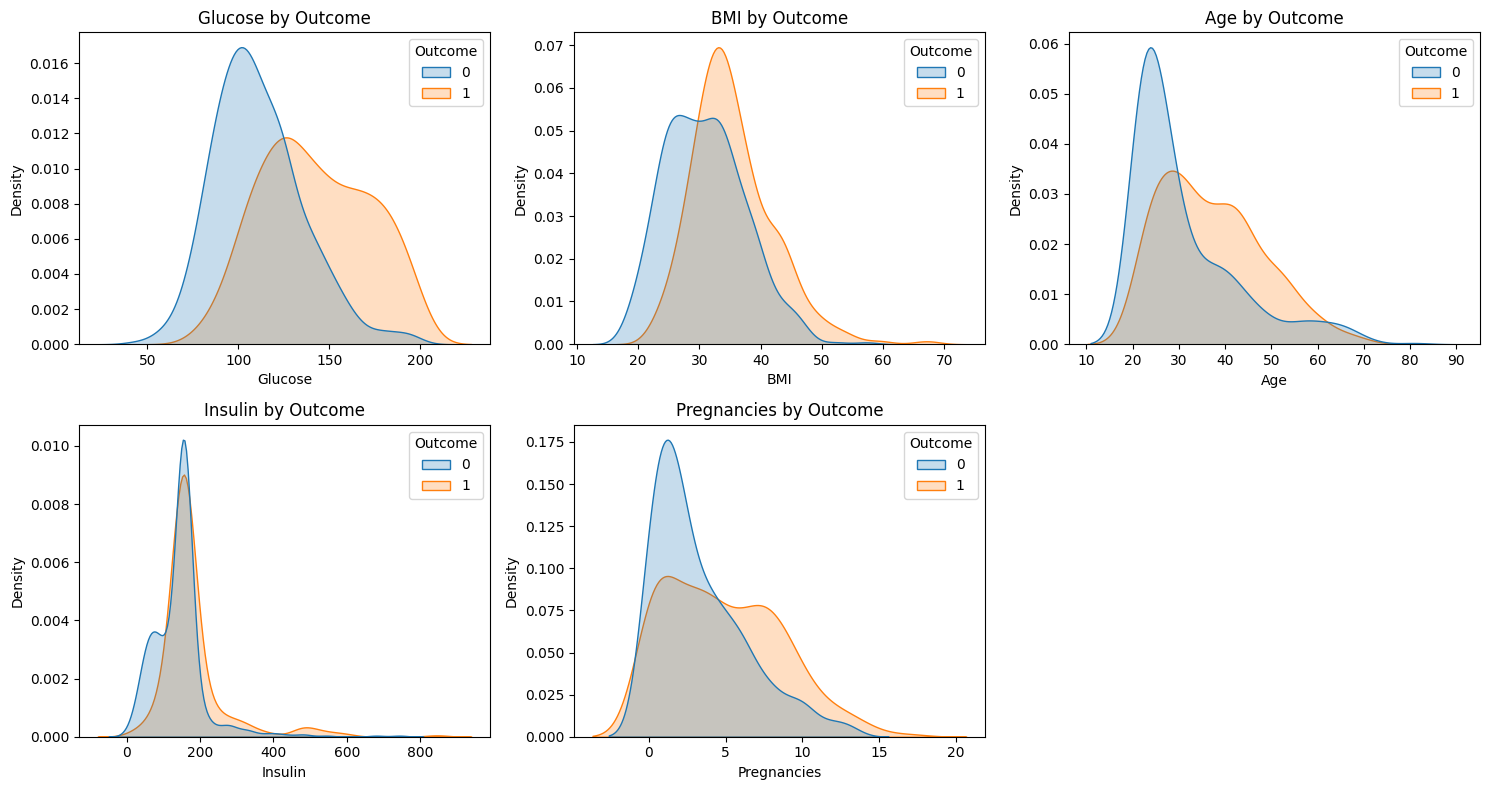

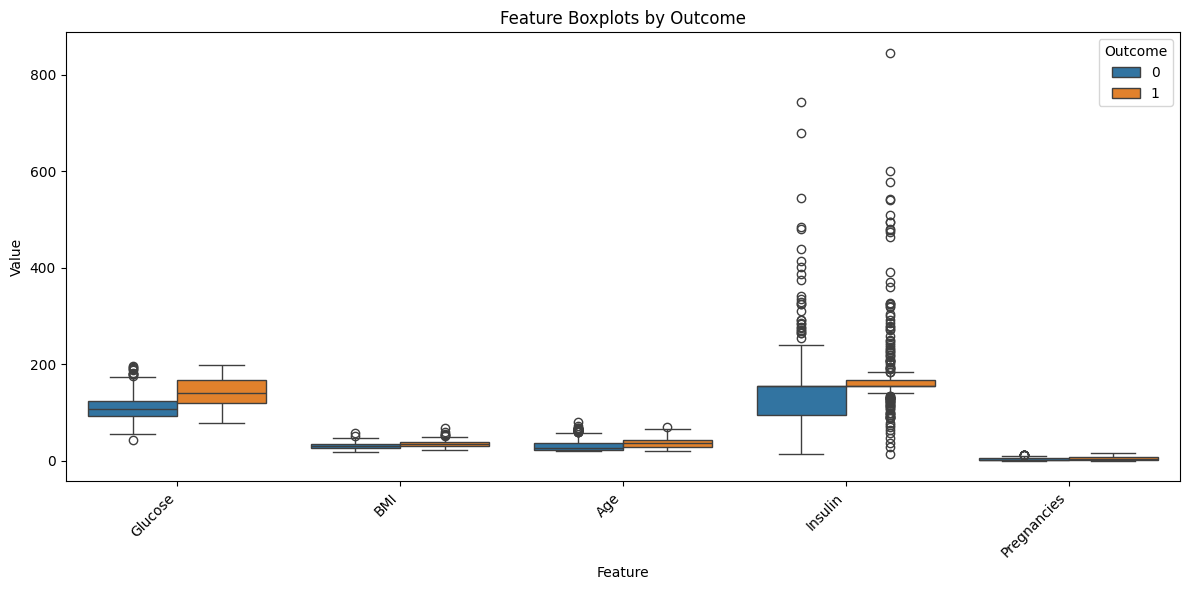

In [48]:
# Feature distributions by Outcome
import seaborn as sns
import matplotlib.pyplot as plt

features = ["Glucose","BMI","Age","Insulin","Pregnancies"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.kdeplot(data=df, x=col, hue='Outcome', common_norm=False, fill=True, ax=axes[i])
    axes[i].set_title(f"{col} by Outcome")

axes[-1].axis('off')  # empty subplot
plt.tight_layout()
plt.show()

# Boxplots by Outcome
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.melt(id_vars='Outcome', value_vars=features, var_name='Feature', value_name='Value'),
            x='Feature', y='Value', hue='Outcome')
plt.title('Feature Boxplots by Outcome')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [49]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
# Deep MLP (>= 7 hidden layers): evaluate overfitting, MAE, MSE, RMSE and select best
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import math
import pickle

# Reuse X, y from earlier; if not defined (e.g. re-run cell), define defaults
try:
    X
    y
except NameError:
    url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    df = pd.read_csv(url)
    df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] = \
        df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0, np.nan)
    df.fillna(df.mean(), inplace=True)
    # Top features based on correlation seen earlier
    X = df[["Glucose","BMI","Age","Insulin","Pregnancies"]]
    y = df["Outcome"]

# Split into train/val/test for proper generalization assessment
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Candidate deep architectures (>= 7 hidden layers each)
architectures = [
    (64, 64, 32, 32, 16, 16, 8),
    (128, 64, 64, 32, 32, 16, 8, 4),
    (256, 128, 64, 64, 32, 16, 8, 4, 2),
]

results = []
best_model = None
best_val_rmse = float("inf")
best_arch = None

for arch in architectures:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=arch,
            activation="relu",
            solver="adam",
            alpha=1e-4,                 # L2 regularization to mitigate overfitting
            batch_size=32,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,        # uses internal validation from training set
            n_iter_no_change=20,
            random_state=42,
        )),
    ])

    pipe.fit(X_train, y_train)

    # Predictions for metrics
    y_pred_train = pipe.predict(X_train)
    y_pred_val = pipe.predict(X_val)

    # Metrics on train
    train_acc = accuracy_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = math.sqrt(train_mse)

    # Metrics on val
    val_acc = accuracy_score(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_rmse = math.sqrt(val_mse)

    # Overfitting assessment: gap between train and val performance
    overfit_gap_rmse = val_rmse - train_rmse
    overfit_gap_acc = train_acc - val_acc

    results.append({
        "architecture": arch,
        "num_hidden_layers": len(arch),
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "train_mse": train_mse,
        "val_mse": val_mse,
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "overfit_gap_rmse": overfit_gap_rmse,
        "overfit_gap_acc": overfit_gap_acc,
    })

    # Track best by validation RMSE
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = pipe
        best_arch = arch

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by=["val_rmse", "overfit_gap_rmse"]).reset_index(drop=True)
print("=== Deep MLP Results (sorted by val RMSE) ===")
print(results_df_sorted[[
    "architecture", "num_hidden_layers",
    "train_acc", "val_acc",
    "train_mae", "val_mae",
    "train_mse", "val_mse",
    "train_rmse", "val_rmse",
    "overfit_gap_rmse", "overfit_gap_acc"
]])

# Evaluate best model on held-out test set
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = math.sqrt(test_mse)

print("\n=== Best Architecture ===")
print({"architecture": best_arch, "num_hidden_layers": len(best_arch)})
print("Test metrics => ", {"accuracy": test_acc, "mae": test_mae, "mse": test_mse, "rmse": test_rmse})

# Optionally save best model
with open("diabetes_mlp7.sav", "wb") as f:
    pickle.dump(best_model, f)

best_arch


=== Deep MLP Results (sorted by val RMSE) ===
                          architecture  num_hidden_layers  train_acc  \
0          (64, 64, 32, 32, 16, 16, 8)                  7   0.787709   
1      (128, 64, 64, 32, 32, 16, 8, 4)                  8   0.783985   
2  (256, 128, 64, 64, 32, 16, 8, 4, 2)                  9   0.800745   

    val_acc  train_mae   val_mae  train_mse   val_mse  train_rmse  val_rmse  \
0  0.721739   0.212291  0.278261   0.212291  0.278261    0.460750  0.527504   
1  0.704348   0.216015  0.295652   0.216015  0.295652    0.464774  0.543739   
2  0.669565   0.199255  0.330435   0.199255  0.330435    0.446380  0.574835   

   overfit_gap_rmse  overfit_gap_acc  
0          0.066754         0.065970  
1          0.078965         0.079637  
2          0.128455         0.131180  

=== Best Architecture ===
{'architecture': (64, 64, 32, 32, 16, 16, 8), 'num_hidden_layers': 7}
Test metrics =>  {'accuracy': 0.75, 'mae': 0.25, 'mse': 0.25, 'rmse': 0.5}


(64, 64, 32, 32, 16, 16, 8)